In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
import pyloras
from xgboost import XGBClassifier

In [2]:
# Load the dataset
data = pd.read_csv(r"C:\Users\kagan\Desktop\Makine_öğrenmesi_Projesi\data set.csv\data set.csv")

In [3]:
# Drop the "Consumer ID" column
data = data.iloc[:, 1:]

In [4]:
#I will drop the CONS_NO column since it seems to provide no information as well as being of string type
data = data.drop("CONS_NO", axis=1)

In [5]:
# Check summary statistics
summary_stats = data.describe()

In [6]:
# Check the number of instances of each class
class_counts = data['FLAG'].value_counts()

In [7]:
# Fill missing values using bilinear interpolation
data.interpolate(method='linear', inplace=True)

In [8]:
#as you will see here the interpolation technique is not enough to replace all missing values of the dataset 
missing_percentage = (data.isna().sum() / len(data)) * 100
missing_percentage
# Assuming your DataFrame is named "data"
missing_values = data.isna().sum()

# To get the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

print("Missing values per column:")
print([x for x in missing_values if x!=0])
print("Total missing values in the DataFrame:", total_missing_values)

Missing values per column:
[3, 10195, 1, 1]
Total missing values in the DataFrame: 10200


In [9]:
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

['4/19/2014', '10/3/2014', '7/9/2015', '7/10/2015']


In [10]:
#filling missing values with the mode of the column
for i in columns_with_missing_values:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [11]:
#now we check if there's any missing data left
missing_values = data.isna().sum()
print(missing_values.sum())
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

0
[]


In [12]:
# Scale the data using Min-Max scaling
scaler = MinMaxScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])

In [13]:
import time
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

# Bağımsız değişkenler (X) ve hedef değişken (y)
X = data.iloc[:, :-1]
y = data['FLAG']

# Veriyi eğitim ve test setlerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
# ADASYN uygula
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Geçen süre: {elapsed_time} saniye")


# Dengeleme sonrası veriyi incele
print("Eğitim seti sınıf dağılımı:")
print(y_train.value_counts())

print("\nEğitim seti (ADASYN sonrası) sınıf dağılımı:")
print(pd.Series(y_train_balanced).value_counts())


Geçen süre: 3.691831350326538 saniye
Eğitim seti sınıf dağılımı:
FLAG
0    31032
1     2865
Name: count, dtype: int64

Eğitim seti (ADASYN sonrası) sınıf dağılımı:
FLAG
0    31032
1    30875
Name: count, dtype: int64


Text(0.5, 1.0, 'Train')

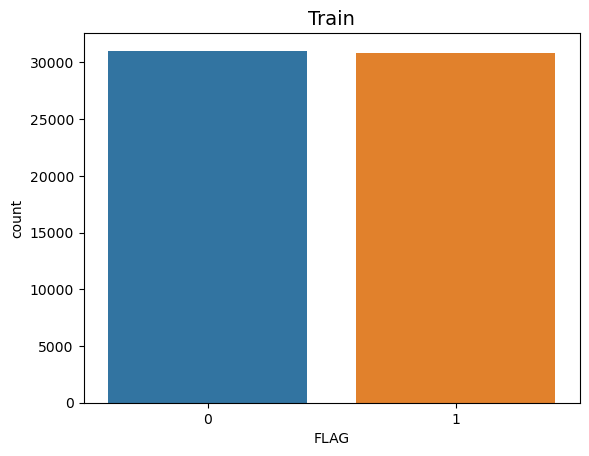

In [14]:
import seaborn as sns
sns.countplot(x=y_train_balanced)
plt.title('Train', fontsize=14)

Text(0.5, 1.0, 'Test')

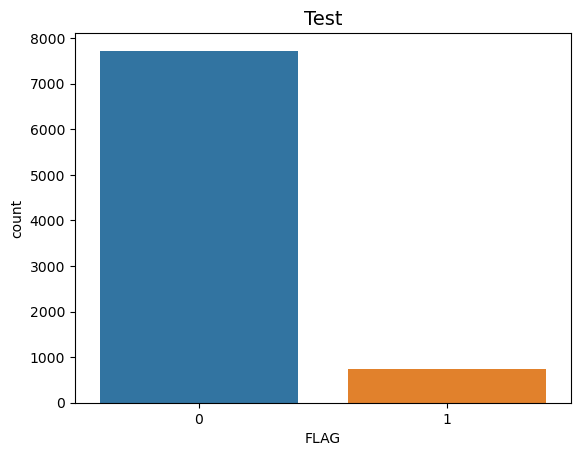

In [15]:
import seaborn as sns
sns.countplot(x=y_test)
plt.title('Test', fontsize=14)

In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost modelini tanımla
model = xgb.XGBClassifier()

# Modeli eğit
model.fit(X_train_balanced, y_train_balanced)

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini yazdır
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9335693215339234

Confusion Matrix:
[[7412  313]
 [ 250  500]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7725
           1       0.62      0.67      0.64       750

    accuracy                           0.93      8475
   macro avg       0.79      0.81      0.80      8475
weighted avg       0.94      0.93      0.93      8475



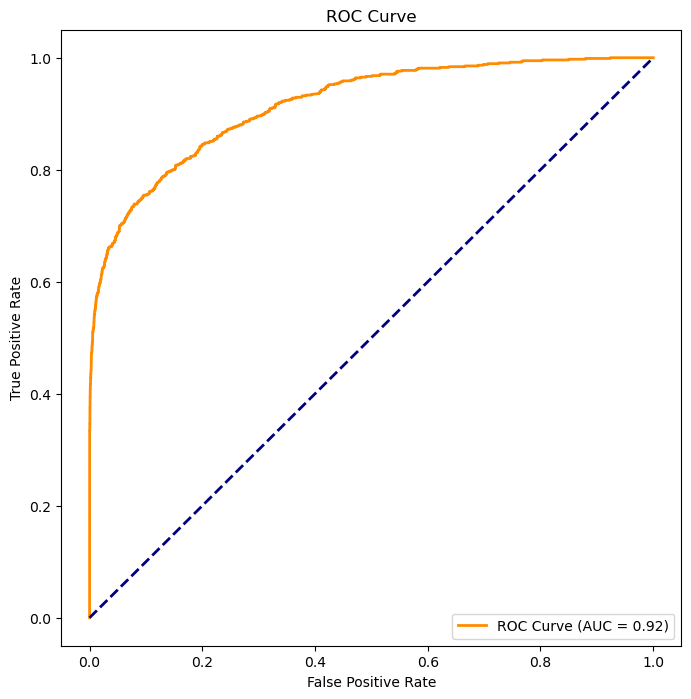

In [17]:
# Test seti üzerinde tahmin olasılıklarını al
from sklearn.metrics import roc_curve, auc
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# ROC Curve çizdir
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()